In [1]:
import sys
sys.version

'3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]'

In [68]:
!pip install torch
!pip install -Uqq fastai duckduckgo_search
!pip install fastdownload
!pip install pathlib
!pip install nbdev
!pip install ipywidgets

In [74]:
#/export
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.widgets import *
# Using lite backend and limit the number of results
from itertools import islice

In [28]:
#/export
ddgs = DDGS()

def search_images(term, max_images = 150):
    print(f"searching for '{term}'")
    keywords = term
    ddgs_images = ddgs.images(keywords)
    limited_images = list(islice(ddgs_images, max_images))
    return L(limited_images).itemgot('image')

In [7]:
vegan_dishes = search_images('"vegan dishes"', max_images=1)
print(len(vegan_dishes))
vegan_dishes[0]

searching for '"vegan dishes"'
1


'http://cok.net/wp-content/uploads/2018/07/IMG_20180613_150406_086-1024x1024.jpg'

In [8]:
from fastdownload import download_url
dest = 'vegan.jpg'
download_url(vegan_dishes[0], dest, show_progress=False)

Path('vegan.jpg')

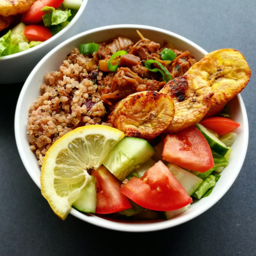

In [9]:
from fastai.vision.all import *
Image.open(dest).to_thumb(256,256)

searching for '"meat dishes"'


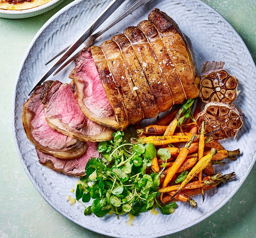

In [10]:
download_url(search_images('"meat dishes"', max_images=1)[0], 'meat.jpg', show_progress=False)
Image.open('meat.jpg').to_thumb(256,256)

In [29]:
#/export

from pathlib import Path
from time import sleep
dishes = 'vegan dish', 'meat dish', 'chicken dish'
path = Path('dishes')

if not path.exists():
    path.mkdir()
    for o in dishes:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o} photo'))
        sleep(10)  # Pause between searches to avoid over-loading server
        resize_images(path/o, max_size=400, dest=path/o)

searching for 'vegan dish photo'
searching for 'meat dish photo'
searching for 'chicken dish photo'


In [98]:
fns = get_image_files(path)

KeyboardInterrupt: 

In [30]:
#/export

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#14) [None,None,None,None,None,None,None,None,None,None...]

In [31]:
len(failed)

14

In [36]:
#/export

dishes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256)
)

In [21]:
#/export

dls = dishes.dataloaders(path)

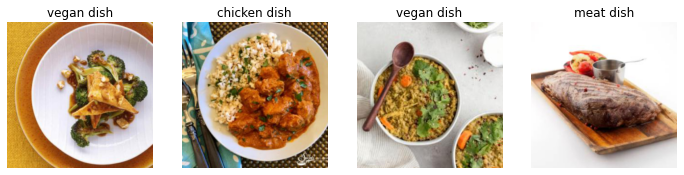

In [37]:
dishes.dataloaders(path).valid.show_batch(max_n=4, nrows=1)

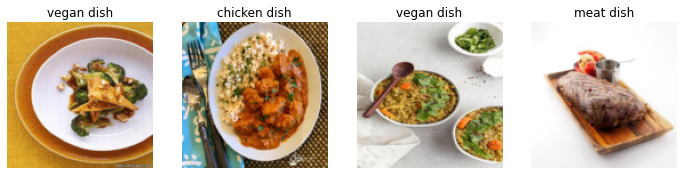

In [38]:
dishes = dishes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dishes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

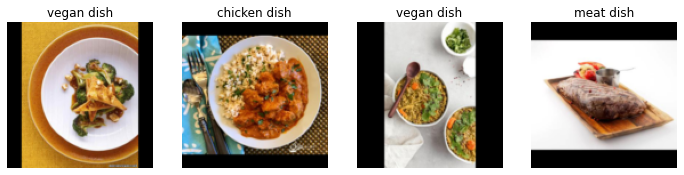

In [39]:
dishes = dishes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dishes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

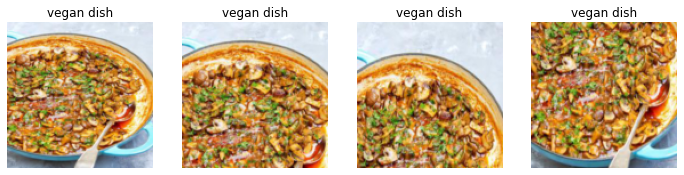

In [40]:
dishes = dishes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dishes.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

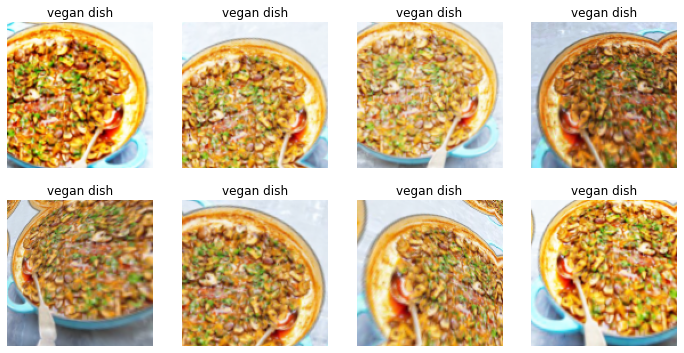

In [41]:
dishes = dishes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dishes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

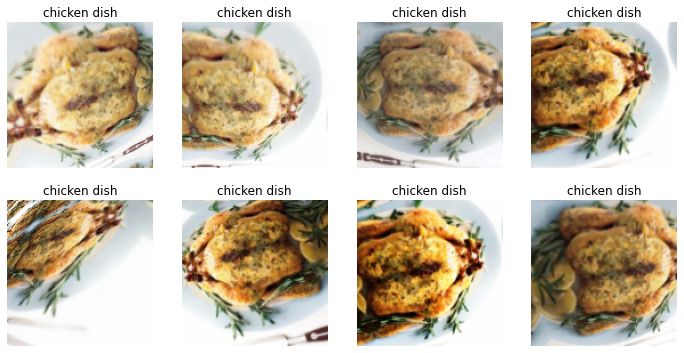

In [27]:
dishes = dishes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dishes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [42]:
#/export

dishes = dishes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dishes.dataloaders(path)

In [43]:
#/export

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\ekino\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ekino\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.044920,1.214126,0.412500,00:36


epoch,train_loss,valid_loss,error_rate,time
0,1.220831,0.886951,0.325000,00:54
1,1.069368,0.763821,0.275000,00:55
2,0.961594,0.613059,0.262500,00:54
3,0.890815,0.598521,0.237500,00:58


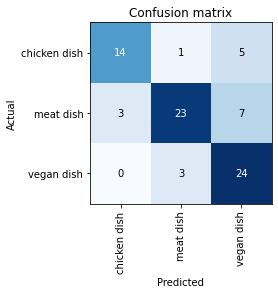

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

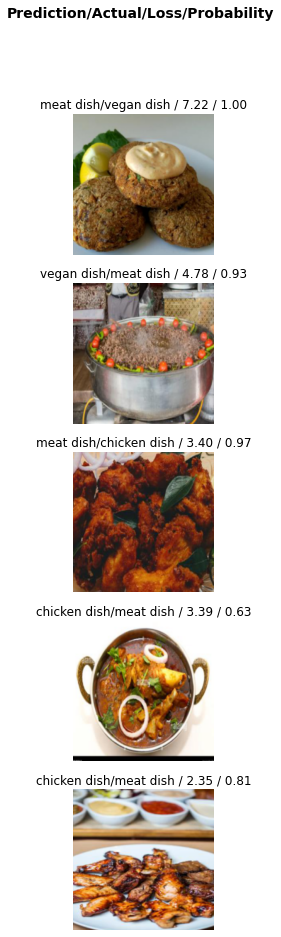

In [48]:
interp.plot_top_losses(5, nrows=5)

In [78]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [79]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [85]:
categories = ['chicken', 'meat', 'vegan']

for category in categories:
    for idx, dish in cleaner.change():
        dst = path / category / dish
        if dst.exists():
            # Handle the conflict by renaming the file
            new_filename = dst.stem + "_new" + dst.suffix
            new_dst = dst.with_name(new_filename)
            try:
                shutil.move(str(cleaner.fns[idx]), new_dst)
            except FileNotFoundError:
                print(f"File {cleaner.fns[idx]} not found.")
        else:
            try:
                shutil.move(str(cleaner.fns[idx]), dst)
            except FileNotFoundError:
                print(f"File {cleaner.fns[idx]} not found.")

File dishes\vegan dish\ccb57539-2f1e-4f1d-b39b-eea5c918e34b.jpg not found.
File dishes\vegan dish\ccb57539-2f1e-4f1d-b39b-eea5c918e34b.jpg not found.
File dishes\vegan dish\ccb57539-2f1e-4f1d-b39b-eea5c918e34b.jpg not found.


In [89]:
dishes = dishes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dishes.dataloaders(path)

In [90]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.112297,1.208184,0.412500,00:42


epoch,train_loss,valid_loss,error_rate,time
0,1.179277,1.077989,0.400000,00:59
1,0.989608,0.932456,0.300000,01:08
2,0.864922,1.042256,0.312500,01:03
3,0.787924,1.063639,0.337500,01:01


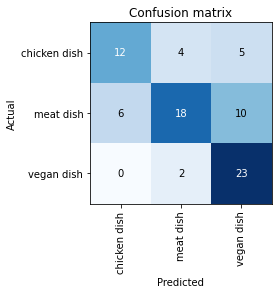

In [91]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

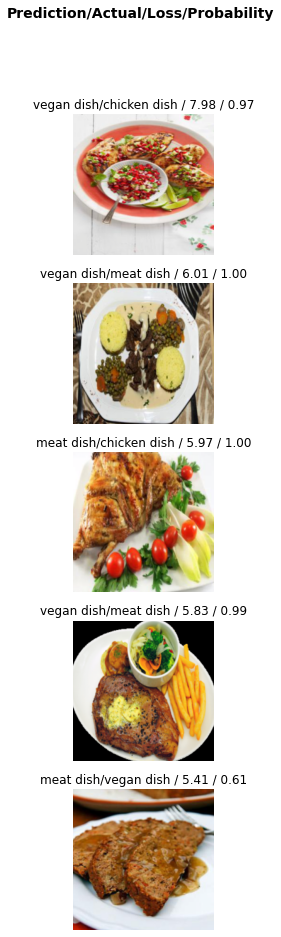

In [92]:
interp.plot_top_losses(5, nrows=5)

In [94]:
is_vegan,_,probs = learn.predict(PILImage.create('meat.jpg'))
print(f"This is a: {is_vegan}.")
print(f"Probability it's a vegan dish: {probs[0]:.4f}")

This is a: meat dish.
Probability it's a vegan dish: 0.0711


In [95]:
learn.export()

In [96]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [99]:
learn_inf = load_learner(path/'export.pkl')

In [100]:
learn_inf.predict('vegan.jpg')
learn_inf.dls.vocab

['chicken dish', 'meat dish', 'vegan dish']

In [113]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [114]:
?FileUpload()

Object `FileUpload()` not found.


In [116]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['vegan.jpg'])

In [102]:
img = PILImage.create(btn_upload.data[-1])

In [103]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [105]:
pred,pred_idx,probs = learn_inf.predict(img)

In [106]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: vegan dish; Probability: 0.7721')

In [107]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [108]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [109]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [111]:
#hide_output
VBox([widgets.Label('Select your dish!'), 
      btn_upload, btn_run, out_pl, lbl_pred])